# Diagnosing the BOLD data

In [1]:
%matplotlib inline

We make sure we have some useful libraries loaded:

In [2]:
import os
import numpy as np # array manipulation
import matplotlib.pyplot as plt # plotting library

Set some defaults for plotting:

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

We need the library to load and analyze images:

In [4]:
from nipy import load_image
from nipy.core.api import Image, drop_io_dim, rollimg
from nipy.algorithms.utils.pca import pca_image
from nipy.algorithms.diagnostics import screens

Get the image to look at.  We will use the first BOLD EPI run from subject 9 of the OpenFMRI `ds114` dataset:

In [5]:
subj_dir = 'sub009'

In [6]:
bold_fname = os.path.join(subj_dir, 'BOLD/task002_run001/bold.nii.gz')

The image is 4D, containing 173 volumes each of 64 by 64 by 30 voxels:

In [7]:
img = load_image(bold_fname)
img.shape

(64, 64, 30, 173)

Load the voxel data into a 4D array:

In [8]:
data = img.get_data()
data.shape

(64, 64, 30, 173)

We can take the standard deviation across time, so now we have a 64 by 64 by 30 volume, where each value is the standard deviation from the mean across the 173 volumes, at this voxel.

In [9]:
time_std_array = np.std(data, axis=3) # standard deviation along the last axis

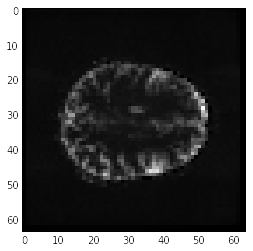

In [10]:
plt.imshow(time_std_array[:, :, 17])

Artefacts in the BOLD volumes can show themselves as sets of voxels that covary together across time.  The voxels covary together because the artefact affects many voxels at the same time.

Examples of artefacts are subject movement, and drifts in scanner sensitivity.

We can use principal components analysis to find patterns of voxels that covary in time:

In [11]:
img_pca_results = pca_image(img, axis='t', ncomp=10)

/usr/local/lib/python2.7/dist-packages/nipy/algorithms/utils/pca.py:143: RuntimeWarning: divide by zero encountered in divide
  return np.where(rmse<=0, 0, 1. / rmse)


The PCA makes a new representation of the data.  Here I'm using the notation from "A tutorial on principal component analysis" by Jonathan Shlems (http://arxiv.org/abs/1404.1100)

Call the number of time points $T$ ($T = 173$ in our case).  Call the number of voxels $V$ ($V = 64 * 64 * 30 = 122880$ in our case).  PCA is going to generate a new matrix $\bf{P}$ such that:

Call the data array $\bf{D}$, where $\bf{D}$ is a $T$ by $V$ array formed from our `data` above rearranged to have time as the first axis and voxel as the second axis.  This is the same as the `time_by_voxels` array in the [verb_task](verb_task.ipynb) notebook.

Get the mean from each column of $\bf{D}$ and subtract this mean from all values in the matching column, to give a new matrix $\bf{X}$ that has columns with mean of zero.

PCA does the following transformation:

$$
\bf{Y} = \bf{P} \bf{X}
$$

- $\bf{P} \bf{X}$ is the [matrix multiplication](http://en.wikipedia.org/wiki/Matrix_multiplication) of $\bf{P}$ onto $\bf{X}$;
- $\bf{P}$ is the $T$ by $T$ *basis vector* matrix, where each row is one basis vector. A basis vector can also be called a *principal component*.
- $\bf{Y}$ is a $T$ by $V$ *basis projection* matrix where each row of $\bf{Y}$ is completely orthogonal (therefore, uncorrelated) with every other row in $\bf{Y}$;

In [12]:
img_pca_results.keys()

['basis_vectors over t',
 'axis',
 'basis_projections',
 'basis_vectors',
 'pcnt_var']

In our case, our analysis has dropped one row of $\bf{P}$.  This is because we subtracted the column means of $\bf{D}$ to form $\bf{X}$, so the columns of $\bf{X}$ have $T-1$ degrees of freedom - but this detail is not important:

In [13]:
img_pca_results['basis_vectors'].shape

(173, 172)

You can think of the *basis vectors* as characteristic time-courses in the data, that are shared by many voxels.

The rows of $\bf{P}$ (the `basis vectors`) are ordered by the amount of variance they explain in the data, where the first row explains the largest amount of variance.

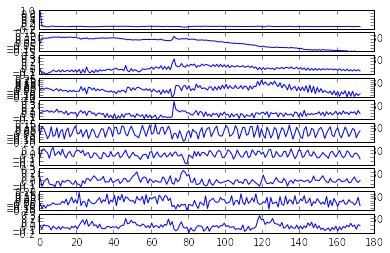

In [14]:
fig, axes = plt.subplots(10, 1)
for i, ax in enumerate(axes):
    ax.plot(img_pca_results['basis_vectors'][:, i])

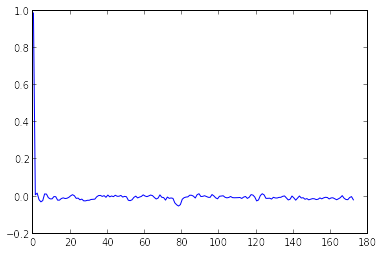

In [15]:
plt.plot(img_pca_results['basis_vectors'][:, 0])

The matrix $\bf{Y}$ (the `basis_projections`) has rows which quantify how much of the corresponding basis vector (corresponding row of $\bf{P}$) is present at each voxel.

Denote row $i$ of a matrix $\bf{M}$ as $m_{i,*}$, and column $j$ as $m_{*,j}$.

With this notation, we can restate the first sentence as saying that the row vector $y_{i,*}$ quantifies how much of the row vector $p_{i,*}$ is expressed in each voxel time course of $x_{*,j}$.

More formally, $y_{i,*}$ is the *projection* of $x_{*,j}$ onto $p_{i,*}$ for every voxel $j = 1..V$.

Of course, the rows of $\bf{Y}$ can also be rearranged from a 1D vector length $V$ (122880 in our case) to a 3D volume of shape 64 by 64 by 30:

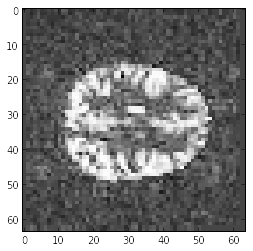

In [16]:
pca0 = img_pca_results['basis_projections']
plt.imshow(pca0.get_data()[:, :, 17, 0])

This image is telling us that there is a large amount (white voxel = positive numbers) of the first principal component (basis vector) around the gray matter.  Looking at the principal component (basis vector) time course above, this means that the first image has much higher signal than the subsequent scans.

We can investigate more by looking directly at where the first image differs from the rest.

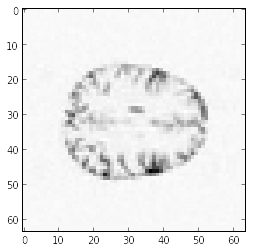

In [17]:
img_data = img.get_data()
vol_0 = img_data[:, :, :, 0]
vol_1 = img_data[:, :, :, 1]
diff_0_1 = vol_1 - vol_0
plt.imshow(diff_0_1[:, :, 17])

Of course this looks rather like the basis vector projection above.  Here is the sagittal view of the same image:

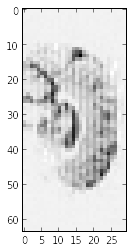

In [18]:
plt.imshow(diff_0_1[32, :, :])

We can save the PCA images in a form that FSL will accept, so we can view them in the FSL image viewer.

In [19]:
import nibabel as nib
data = pca0.get_data()
fixed_img = nib.Nifti1Image(data, None, img.metadata['header'])
nib.save(fixed_img, 'pca_projections.nii.gz')

Now we can look at the image with `fslview`.

Independent components analysis is a very similar technique, implemented in FSL:

http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MELODIC

This does a similar analysis to PCA:

$$
\bf{Y} = \bf{W} \bf{X}
$$

where $\bf{X}$ is the $T$ by $V$ data matrix, as for PCA, $\bf{W}$ is also a $T$ by $T$ matrix, and $\bf{Y}$ is again a $T$ by $V$ matrix.  The difference between ICA and PCA is in the derivation of the matrix $\bf{P}$ (PCA) vs $\bf{W}$ (ICA), and therefore the properties of the transformed data $\bf{Y}$.

We won't worry about the details for now, but just run the FSL ICA:

In [20]:
!fsl5.0-melodic -i sub009/BOLD/task002_run001/bold.nii.gz --report

Now we can look at the ICA time courses (rows of $\bf{W}$) and their corresponding images (rows of $\bf{Y}$), by opening the report output at ``sub009/BOLD/task002_run001/bold.ica/report/00index.html``.